In [1]:
import pandas as pd
import numpy as np
import joblib
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pd.options.display.max_seq_items = 2000

# import python modules
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/tabea/Documents/UrbanMobility/src')
from models import random_forest_model as model

# Feature Attribution and Interpretability

### Data & Model Loading

In [9]:
journey_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2017.csv', parse_dates=['end_date', 'start_date'], index_col=0)
journey_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2017.csv', parse_dates=['end_date', 'start_date'], index_col=0)
journey_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2018.csv', parse_dates=['end_date', 'start_date'], index_col=0)
journey_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2019.csv', parse_dates=['end_date', 'start_date'], index_col=0)

In [10]:
journey_train = pd.concat([journey_16, journey_17, journey_18])
journey_test = journey_19.copy()

In [11]:
x_train, y_train, x_test, y_test = model.train_test_split(journey_train, journey_test)

In [12]:
x_test.shape

(101887, 104)

In [ ]:
rf = joblib.load('../models.random_forest.pkl')

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [ ]:
# evaluation metrics
rmse, mae, r2 = model.evaluation_metrics(y_test, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)

### 1. Built in Feature Importance of Tree Models

In [8]:
# feature importance
print(model.get_feature_importance(rf, x_train).to_string())

                                       Feature  Importance
12                                    humidity    0.090441
15                                   windspeed    0.088993
17                                  visibility    0.088915
11                                         dew    0.083702
16                                  cloudcover    0.082192
10                                   feelslike    0.080580
9                                         temp    0.078235
1                                         hour    0.069903
8                                  day_of_year    0.064755
7                                 day_of_month    0.063487
0                                  day_of_week    0.043654
4                                        month    0.037325
18                                     uvindex    0.028669
3                                  part_of_day    0.020097
5                                       season    0.019097
14                                    windgust    0.0144

### 2. Accumulated Local Effects Plot

In [46]:
from alibi.explainers import ALE, plot_ale
import matplotlib.pyplot as plt

feature_names = x_train.columns

ale = ALE(rf.predict, feature_names=feature_names, target_names=['demand'])

###

In [47]:
x_test_np = y_train.values

# Convert feature names to indices
feature_indices = [list(x_test.columns).index(name) for name in feature_names]

# Determine the length of the subset
subset_length = 8500

# Select a contiguous subset of your training set
start_index = 0  # Adjust the start index as needed
end_index = start_index + subset_length
x_test_subset = x_test_np[start_index:end_index]

In [49]:
rf_exp = ale.explain(x_test_subset)

/Users/tabea/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/tabea/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/tabea/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/tabea/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/tabea/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


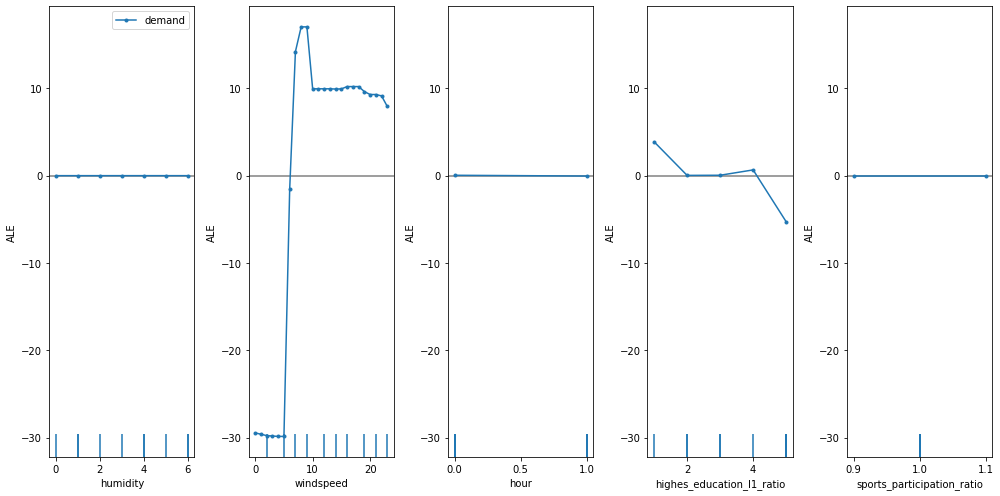

In [50]:
plot_ale(rf_exp, n_cols=6, fig_kw={'figwidth':14, 'figheight': 7});

### Comparing ALE for Random Forest and Gradient Boosting for all the features